# EDA
Sections in this notebook:

- pull raw data from csv
- explore data
    - handle missing `selftext`
- apply vectorizers & check out results
    - define X & y and find baseline
    - train-test split
    - CountVectorizer
        - build custom list of stop-words
    - TfidfVectorizer
- get word counts
- generate word clouds
- initial pass at some models
    - MultinomialNB with CountVectorizer
    - RandomForest with TfidfVectorizer

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from wordcloud import WordCloud

import modeling_reporting

----
## Pull raw posts from csv

In [2]:
posts = pd.read_csv("data/raw_posts.csv")
posts.head()

,title,selftext,subreddit,created_utc,name,type
0,"Why, during freezing weather, does only the wa...",I've seen a fair few videos over the last few ...,askscience,1705598340.0,t3_199vagn,post
1,Is there a limit to how close to the equator a...,With the weakened jet stream in the Northern H...,askscience,1705597614.0,t3_199v01y,post
2,Are there any studies that look at the possibi...,Just thinking about how certain populations pr...,askscience,1705634498.0,t3_19a990j,post
3,"If we see better with dilated pupils, why aren...",Why do our pupils dilate during a fight or fli...,askscience,1705635204.0,t3_19a9hao,post
4,How did patients with high fevers get cured of...,The 1927 Nobel Prize in Medicine awarded to Ju...,askscience,1705663497.0,t3_19agy4w,post


----
## Explore data

In [3]:
posts["subreddit"].value_counts()

subreddit
AskScienceFiction    1197
space                 957
askscience            737
1705175792.0            1
1704209764.0            1
1703002634.0            1
Name: count, dtype: int64

In [4]:
posts = posts.loc[posts["subreddit"].isin(["AskScienceFiction", "space", "askscience"])]
posts["subreddit"].value_counts(normalize=True)

subreddit
AskScienceFiction    0.414044
space                0.331027
askscience           0.254929
Name: proportion, dtype: float64

In [40]:
posts["subreddit"].value_counts()

subreddit
AskScienceFiction    1197
space                 957
askscience            737
Name: count, dtype: int64

In [5]:
# lots of nulls in the `selftext` field
modeling_reporting.find_null_selftext(posts)

{'askscience': 115, 'space': 784, 'AskScienceFiction': 298}

### handle missing `selftext`
- the majority of the "space" subreddit posts have a title and no `selftext` (their body is just a link)
- also happens in the other subreddits, although not as often (see [README](/README.md#missing-selftext) for statistics on missingness)
- copying `title` into the `selftext` column where `selftext` is null

In [6]:
posts[posts["subreddit"] == "space"].head()

,title,selftext,subreddit,created_utc,name,type
737,Investigation will be held into Peregrine's fa...,NaN,space,1705700564.0,t3_19aumxd,post
738,Is there any place to follow the Chinese space...,I’m really interested in the current “Space Ra...,space,1705699706.0,t3_19auad7,post
739,Infinite multiverse,What I like about the infinite multiverse is t...,space,1705699574.0,t3_19au8jf,post
740,Japan's SLIM moon craft short on power after s...,NaN,space,1705698739.0,t3_19atwtl,post
741,Astronomers have snapped a new photo of the bl...,NaN,space,1705697932.0,t3_19atlat,post


In [7]:
posts["selftext"] = posts["selftext"].fillna(posts["title"])

In [8]:
# just verifying that rows that were NOT missing selftext have not been affected
posts[posts["subreddit"] == "space"].head()

,title,selftext,subreddit,created_utc,name,type
737,Investigation will be held into Peregrine's fa...,Investigation will be held into Peregrine's fa...,space,1705700564.0,t3_19aumxd,post
738,Is there any place to follow the Chinese space...,I’m really interested in the current “Space Ra...,space,1705699706.0,t3_19auad7,post
739,Infinite multiverse,What I like about the infinite multiverse is t...,space,1705699574.0,t3_19au8jf,post
740,Japan's SLIM moon craft short on power after s...,Japan's SLIM moon craft short on power after s...,space,1705698739.0,t3_19atwtl,post
741,Astronomers have snapped a new photo of the bl...,Astronomers have snapped a new photo of the bl...,space,1705697932.0,t3_19atlat,post


----
## Apply vectorizers & check out results

### define X & y & find baseline

In [9]:
# setting the subreddit with the most representation as the target
posts["target"] = np.where(posts["subreddit"] == "AskScienceFiction", 1, 0)
posts["target"].value_counts(normalize=True)

target
0    0.585956
1    0.414044
Name: proportion, dtype: float64

there's our **baseline**: the 58.6% of 0, the larger group

### train-test split

In [10]:
X = posts["selftext"]
y = posts["target"]

# choosing a relatively small `test_size` because I don't have as much data as I would like
# `stratify=y` because my classes are imbalanced & I want to make sure to I have similar proportions of both classes in train & test data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42, test_size=.2)

### CountVectorizer

In [11]:
# preliminary check of CountVectorizer, will use a pipeline to try other params later
cvec = CountVectorizer(stop_words="english", max_features=1000, min_df=0.01, max_df=0.9)

X_train_cvec = cvec.fit_transform(X_train)
X_test_cvec = cvec.transform(X_test)

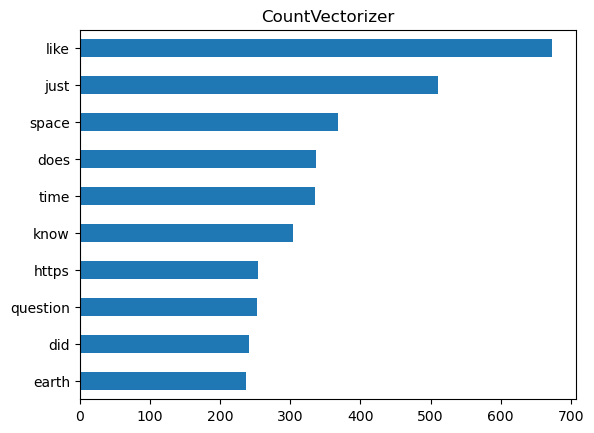

In [12]:
cvec_df = pd.DataFrame(X_train_cvec.todense(), columns=cvec.get_feature_names_out())

cvec_df.sum().sort_values().tail(10).plot(kind="barh", title="CountVectorizer");

### Build custom list of stop words
- we did this in the hackathon
- I added words here based on what shows up in this top-10 graph as well as the word-count df below
- this was an iterative process!
- both CountVectorizer & TfidfVectorizer use the same custom list of stop words
- for discussion about why I included certain words, see the [README](/README.md#custom-stop_words)
- used this list for the `CUSTOM_STOPS` constant in the [modeling_reporting.py](../modeling_reporting.py), which is used in the [model_trials notebook](model_trials.ipynb)

In [13]:
custom_stops = ["https", "did", "does", "just", "like", "question", "space", "know", "ve", "don", "com", "www", "questions", "think", "x200b",
                "youtube", "wiki"]
stops = list(CountVectorizer(stop_words="english").get_stop_words())
stops.extend(custom_stops)

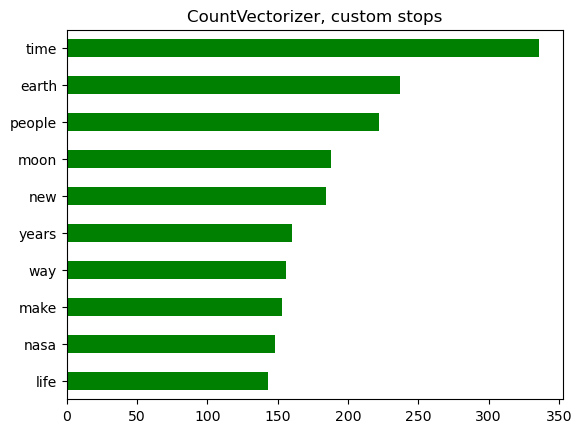

In [14]:
cvec_custom = CountVectorizer(stop_words=stops, max_features=1000, min_df=0.01, max_df=0.9)

X_train_cvec_custom = cvec_custom.fit_transform(X_train)
X_test_cvec_custom = cvec_custom.transform(X_test)

cvec_custom_df = pd.DataFrame(X_train_cvec_custom.todense(), columns=cvec_custom.get_feature_names_out())

cvec_custom_df.sum().sort_values().tail(10).plot(kind="barh", color="green", title="CountVectorizer, custom stops");

### TfidfVectorizer

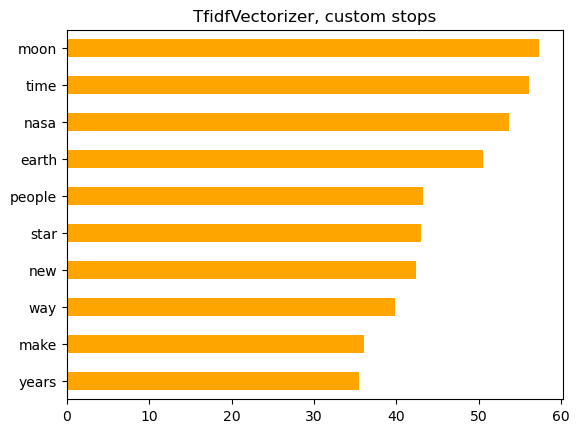

In [15]:
# using the same starting point for TfidfVectorizer, with my custom stop words
tfidf = TfidfVectorizer(stop_words=stops, max_features=1000, min_df=0.01, max_df=0.9)

X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

tfidf_df = pd.DataFrame(X_train_tfidf.todense(), columns=tfidf.get_feature_names_out())

tfidf_df.sum().sort_values().tail(10).plot(kind="barh", color="orange", title="TfidfVectorizer, custom stops");

## Get word counts

In [16]:
tfidf_df.shape

(2312, 335)

In [17]:
# read about `vocabulary_` attribute in this blog: https://www.kdnuggets.com/2022/10/converting-text-documents-token-counts-countvectorizer.html
cvec_words_df = pd.DataFrame.from_dict(cvec_custom.vocabulary_, orient="index", columns=["word_count"])
cvec_words_df.shape

(335, 1)

In [18]:
cvec_words_df["word_count"].sort_values().tail(20)

view         315
want         316
war          317
wars         318
watch        319
watching     320
water        321
way          322
week         323
went         324
wonder       325
wondering    326
work         327
working      328
world        329
worth        330
wouldn       331
wrong        332
year         333
years        334
Name: word_count, dtype: int64

In [19]:
tfidf_words_df = pd.DataFrame.from_dict(tfidf.vocabulary_, orient="index", columns=["word_count"])
tfidf_words_df.shape

(335, 1)

In [20]:
tfidf_words_df["word_count"].sort_values().tail(20)

view         315
want         316
war          317
wars         318
watch        319
watching     320
water        321
way          322
week         323
went         324
wonder       325
wondering    326
work         327
working      328
world        329
worth        330
wouldn       331
wrong        332
year         333
years        334
Name: word_count, dtype: int64

In [21]:
matches = cvec_words_df["word_count"].sort_values() == tfidf_words_df["word_count"].sort_values()
matches.value_counts()

word_count
True    335
Name: count, dtype: int64

- no "False" means that both CountVectorizer & TfidfVectorizer made exactly the same set of tokens
- not too surprising since I didn't change their default regex and used the same params for both

### Look at word count by subreddit
- there's probably a better way to do this...

In [22]:
X_pos_class = posts.loc[posts["target"] == 1]["selftext"]  # this will be the 'AskScienceFiction' subreddit
X_neg_class = posts.loc[posts["target"] == 0]["selftext"]  # this will be 'space' and 'askscience'

cvec_custom.fit_transform(X_pos_class)
pos_class_vocab = pd.DataFrame.from_dict(cvec_custom.vocabulary_, orient="index", columns=["word_count"])

cvec_custom.fit_transform(X_neg_class)
neg_class_vocab = pd.DataFrame.from_dict(cvec_custom.vocabulary_, orient="index", columns=["word_count"])

In [23]:
print(f"shape: {pos_class_vocab.shape}")
pos_class_vocab["word_count"].sort_values().tail()

shape: (405, 1)


world     400
wouldn    401
wrong     402
year      403
years     404
Name: word_count, dtype: int64

In [24]:
print(f"shape: {neg_class_vocab.shape}")
neg_class_vocab["word_count"].sort_values().tail()

shape: (363, 1)


world     358
worth     359
wouldn    360
year      361
years     362
Name: word_count, dtype: int64

In [25]:
# need to get to the words and not the counts
neg_class_vocab.index

Index(['seen', 'days', 'people', 'ice', 'water', 'ground', 'explain',
       'climate', 'change', 'scientists',
       ...
       'lunar', 'astronomers', 'spacex', 'launches', 'rockets', 'astronauts',
       'webb', 'artemis', 'falcon', 'missions'],
      dtype='object', length=363)

In [26]:
# are the words in the negative class all also in the positive class
#  this is False, which is good for modeling!
set(neg_class_vocab.index).issubset(set(pos_class_vocab.index))

False

In [27]:
# how many words are not repeated?
len(set(neg_class_vocab.index).difference(set(pos_class_vocab.index)))

203

In [28]:
# are there words in the full dataset that are not found in the vectorized training data?
# False here, meaning yes there are
set(cvec_words_df.index).issubset(set(pos_class_vocab.index).union(set(neg_class_vocab.index)))

False

In [29]:
# how many words are in the un-vectorized, full data set that are not in the vectorized training data?
len((set(pos_class_vocab.index).union(set(neg_class_vocab.index))).difference(set(cvec_words_df.index)))

274

In [30]:
set(cvec_words_df.index)

{'000',
 '10',
 '20',
 '2023',
 '2024',
 'able',
 'actually',
 'affect',
 'age',
 'ago',
 'air',
 'alien',
 'animal',
 'animals',
 'answer',
 'apparently',
 'appear',
 'appreciated',
 'area',
 'areas',
 'aren',
 'ask',
 'asking',
 'assume',
 'assuming',
 'astronaut',
 'atmosphere',
 'aware',
 'away',
 'based',
 'basically',
 'batman',
 'believe',
 'best',
 'better',
 'big',
 'bit',
 'black',
 'blood',
 'blue',
 'body',
 'book',
 'brain',
 'build',
 'called',
 'came',
 'case',
 'cause',
 'causes',
 'certain',
 'change',
 'character',
 'city',
 'close',
 'cold',
 'come',
 'comes',
 'comics',
 'comments',
 'control',
 'covered',
 'create',
 'curious',
 'current',
 'currently',
 'dark',
 'day',
 'days',
 'dc',
 'dead',
 'death',
 'deep',
 'despite',
 'didn',
 'die',
 'difference',
 'different',
 'directly',
 'doesn',
 'doing',
 'early',
 'earth',
 'edit',
 'effect',
 'end',
 'energy',
 'entire',
 'especially',
 'exactly',
 'example',
 'exist',
 'experience',
 'explain',
 'family',
 'far',


In [31]:
# that seems like a lot! what are they?
(set(pos_class_vocab.index).union(set(neg_class_vocab.index))).difference(set(cvec_words_df.index))

{'100',
 '12',
 '15',
 '24',
 '27',
 '30',
 'abilities',
 'ability',
 'absolutely',
 'act',
 'actual',
 'advanced',
 'alive',
 'allowed',
 'america',
 'answering',
 'apollo',
 'artemis',
 'article',
 'aside',
 'askscience',
 'astronauts',
 'astronomers',
 'astronomy',
 'attack',
 'avengers',
 'average',
 'bad',
 'battle',
 'beings',
 'biology',
 'born',
 'break',
 'bring',
 'brought',
 'bruce',
 'bunch',
 'capable',
 'captain',
 'care',
 'cells',
 'characters',
 'chemistry',
 'child',
 'children',
 'china',
 'chinese',
 'clear',
 'clearly',
 'climate',
 'comic',
 'coming',
 'completely',
 'conditions',
 'considered',
 'contact',
 'cool',
 'couldn',
 'crazy',
 'created',
 'creating',
 'crime',
 'damage',
 'data',
 'deal',
 'destroy',
 'destroyed',
 'details',
 'died',
 'discovered',
 'discovery',
 'discuss',
 'distance',
 'dna',
 'doctor',
 'dr',
 'eat',
 'effects',
 'empire',
 'en',
 'engineering',
 'episode',
 'esa',
 'event',
 'events',
 'eventually',
 'evil',
 'exploration',
 'extra

- the original vocabulary (in the `cvec_words_df` & `tfidf_words_df` above) came from only the `X_train` data, 80% of all the data 
- that vocabulary also had stop-words removed
- the `pos_class_vocab` & `neg_class_vocab` came from the whole, unsplit dataset with no stop-words removed and also none of the other words/tokens removed that don't match the default regex used by the vectorizer
- however, 274 words in the unvectorized, full data set that are not in the vectorized training data seems like a lot! especially when the word count for that vectorized training data is only 335
- I suspect the difference comes down to the other params in the vectorizers: 
    - `max_features=1000`: some wishful thinking there! even if I took the union of those sets, I'd have well under 1,000 features
    - `min_df=0.01` & `max_df=0.9`: so these 274 words must be either in too few or too many of the posts

#### saving the positive & negative class vocabulary to use in model analysis

In [37]:
pos_class_vocab["word"] = pos_class_vocab.index
pos_class_vocab.head()

,word_count,word
start,335,start
power,277,power
obviously,258,obviously
damage,83,damage
body,41,body


In [38]:
neg_class_vocab["word"] = neg_class_vocab.index

In [39]:
pos_class_vocab.to_csv("data/pos_class_vocab.csv", index=False)
neg_class_vocab.to_csv("data/neg_class_vocab.csv", index=False)

## Generate word clouds
- Sonyah suggested this visualization
- [source](https://medium.com/mlearning-ai/wordclouds-with-python-c287887acc8b)

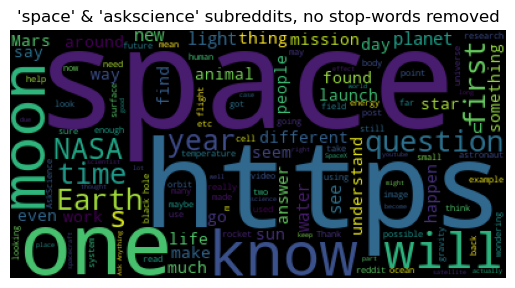

In [32]:
# WordCloud wants a block of text so I'm re-joining back into a single block
neg_wc = WordCloud().generate(" ".join(X_neg_class))
plt.imshow(neg_wc)
plt.axis("off")
plt.title("'space' & 'askscience' subreddits, no stop-words removed");

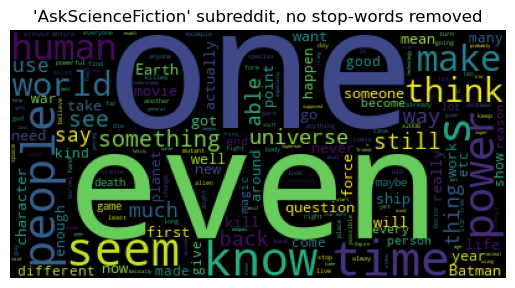

In [33]:
pos_wc = WordCloud().generate(" ".join(X_pos_class))
plt.imshow(pos_wc)
plt.axis("off")
plt.title("'AskScienceFiction' subreddit, no stop-words removed");

----
## Inital pass at some models

### MultinomialNB with CountVectorizer

In [34]:
# from lesson 2.06
multi = MultinomialNB()
multi.fit(X_train_cvec_custom, y_train)
multi_preds = multi.predict(X_test_cvec_custom)

tn, fp, fn, tp = confusion_matrix(y_test, multi_preds).ravel()

multi_metrics = {
    "score_train": multi.score(X_train_cvec_custom, y_train),
    "score_test": multi.score(X_test_cvec_custom, y_test),
    "sensitivity": tp / (tp + fn),
    "specificity": tn / (tn + fp)
}

multi_metrics

{'score_train': 0.8313148788927336,
 'score_test': 0.8082901554404145,
 'sensitivity': 0.7666666666666667,
 'specificity': 0.8377581120943953}

In [35]:
# from lesson 2.09
rf = RandomForestClassifier()
rf.fit(X_train_tfidf, y_train)
rf_preds = rf.predict(X_test_tfidf)

tn, fp, fn, tp = confusion_matrix(y_test, rf_preds).ravel()

rf_metrics = {
    "score_train": rf.score(X_train_tfidf, y_train),
    "score_test": rf.score(X_test_tfidf, y_test),
    "sensitivity": tp / (tp + fn),
    "specificity": tn / (tn + fp)
}

rf_metrics

{'score_train': 0.9705882352941176,
 'score_test': 0.7754749568221071,
 'sensitivity': 0.75,
 'specificity': 0.7935103244837758}